## importing libraries...

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Embedding,TextVectorization
import re
import random
import tensorflow
from keras.utils import to_categorical

In [2]:
# ignore warnings....
warnings.filterwarnings("ignore")

## Manipulate Data...

In [120]:
train_df = pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test_df = pd.read_csv("Corona_NLP_test.csv",encoding='latin1')

train_df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1015,4814,49766,"Vancouver, Canada",17-03-2020,Today's BCREA Market Intelligence Report: Sket...,Positive
13522,17321,62273,NaN,21-03-2020,If supermarket workers are so ÂessentialÂ th...,Positive
20195,23994,68946,Everywhere,24-03-2020,Stop buying so much toiletpaper. Yes sh**t is ...,Extremely Positive
34339,38138,83090,"London, England",08-04-2020,What share could recovery take @covid19? We us...,Positive
16665,20464,65416,"Montana, USA",22-03-2020,I was wondering why people were having a hard ...,Negative
15766,19565,64517,"St. Catharines, Ontario",22-03-2020,How is your business adapting to #COVID19? Can...,Extremely Positive
6993,10792,55744,NaN,19-03-2020,Grocery store egg shelf completely empty.\r\r\...,Extremely Negative
24691,28490,73442,"Dallas, TX",27-03-2020,With thousands of retail stores temporarily cl...,Positive
8326,12125,57077,NaN,19-03-2020,"To all do the medical workers, first responder...",Extremely Positive
38522,42321,87273,San Antonio,11-04-2020,"""We saw the picture. We understand...What can ...",Positive


In [121]:
# cheking the shape of data....
print(f"Train data-set has {train_df.shape[0]} rows and {train_df.shape[1]} columns \n")
print(f"Test data-set has {test_df.shape[0]} rows and {test_df.shape[1]} columns")

Train data-set has 41157 rows and 6 columns 

Test data-set has 3798 rows and 6 columns


In [122]:
# checking the dtypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [123]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [124]:
# checking null values...
train_df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [125]:
# checking the label proportion around the data...
labels_prop = train_df["Sentiment"].value_counts()
labels_prop

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

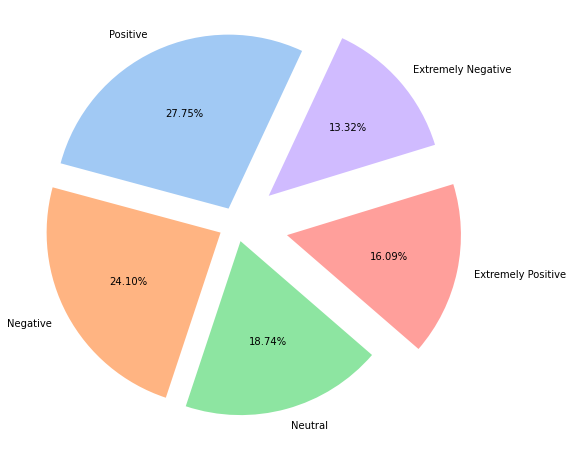

In [126]:
# let's visualize it...
labels = labels_prop.index
colors = sns.color_palette('pastel') # pastel colors
plt.figure(figsize=(10,8))
plt.pie(labels_prop,labels=labels,colors=colors,explode=[0.1,0.1,0.1,0.3,0.25],startangle=65,autopct="%0.2f%%");

In [127]:
# let's visualize the location....
location_prop = train_df["Location"].value_counts()
location_prop

London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: Location, Length: 12220, dtype: int64

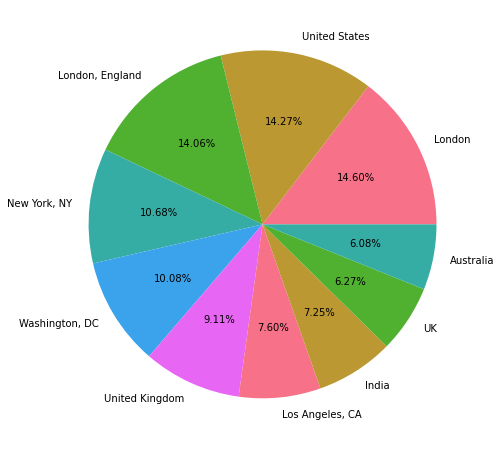

In [128]:
#  just visualize the top 10 location of the data....
labels = location_prop.index[:10]
colors = sns.color_palette("husl")
plt.figure(figsize=(10,8))
plt.pie(location_prop[:10],labels=labels,colors=colors,autopct="%.2f%%",);

In [129]:
# calculate the tweet length
train_df["Length"] = train_df["OriginalTweet"].apply(len)
train_df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Length
27814,31613,76565,NaN,03-04-2020,try to social distance in a supermarket #Coron...,Neutral,153
34630,38429,83381,"New York, NY",08-04-2020,Fastmarkets RISI Viewpoint: What does the COVI...,Negative,316
26174,29973,74925,?? Copenhagen,02-04-2020,Great to wake up to this article in the Expres...,Extremely Positive,194
38798,42597,87549,India,12-04-2020,There is no shortage of grains. We now have a ...,Negative,262
32516,36315,81267,"West Yorkshire, England",07-04-2020,Some1 I used2 know had their NHS badge ripped ...,Neutral,287
33955,37754,82706,NaN,08-04-2020,https://t.co/GzTpr8haz2 via @amazon Need a Gif...,Positive,300
2957,6756,51708,MÃ¼nchen,18-03-2020,How COVID 19 Is Impacting Online Shopping Beha...,Neutral,54
15118,18917,63869,SoCal Desert,22-03-2020,The only thing that was keeping our economy af...,Neutral,148
11218,15017,59969,London,20-03-2020,Don't know about #herdimmunity but we've certa...,Positive,279
17975,21774,66726,Salt Lake City,23-03-2020,The Utah Food Bank said the coronavirus outbre...,Positive,242


<Figure size 720x720 with 0 Axes>

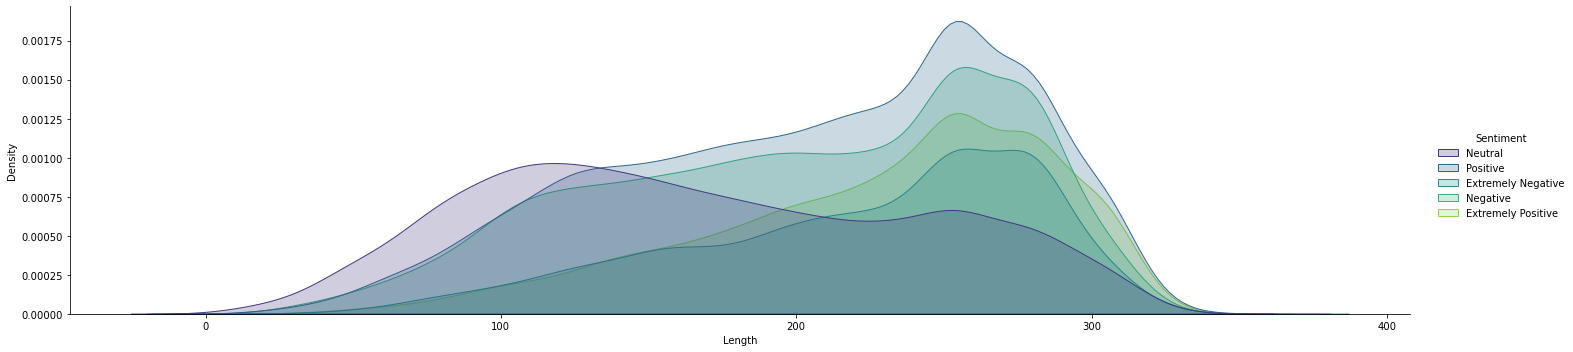

In [130]:
# visualize the tweet length accross the data-set...
plt.figure(figsize=(10,10))
sns.displot(data=train_df,x="Length",hue="Sentiment",
                 kind = 'kde', fill = True,  aspect =4 , palette = "viridis");


In [131]:
# changing the tweet text dtype
train_df["OriginalTweet"] = train_df["OriginalTweet"].astype("string")

In [132]:
train_df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    string
Sentiment        object
Length            int64
dtype: object

In [133]:
# changing the datetime dtype ...
train_df["TweetAt"] = pd.to_datetime(train_df["TweetAt"],format="%d-%m-%Y")
train_df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Length
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,237
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,131
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,306
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310


In [134]:
train_df["TweetAt"].min()

Timestamp('2020-03-16 00:00:00')

In [135]:
train_df["TweetAt"].max()

Timestamp('2020-04-14 00:00:00')

In [136]:
# checking the tweets per day
tweet_per_day  = train_df.groupby(train_df["TweetAt"]).count()["Sentiment"]
tweet_per_day = tweet_per_day.reset_index()
tweet_per_day

,TweetAt,Sentiment
0,2020-03-16,656
1,2020-03-17,1977
2,2020-03-18,2742
3,2020-03-19,3215
4,2020-03-20,3448
5,2020-03-21,2653
6,2020-03-22,2114
7,2020-03-23,2062
8,2020-03-24,1480
9,2020-03-25,2979


In [137]:
tweet_per_day["Month"] = tweet_per_day["TweetAt"].apply(lambda x : x.month)
tweet_per_day

,TweetAt,Sentiment,Month
0,2020-03-16,656,3
1,2020-03-17,1977,3
2,2020-03-18,2742,3
3,2020-03-19,3215,3
4,2020-03-20,3448,3
5,2020-03-21,2653,3
6,2020-03-22,2114,3
7,2020-03-23,2062,3
8,2020-03-24,1480,3
9,2020-03-25,2979,3


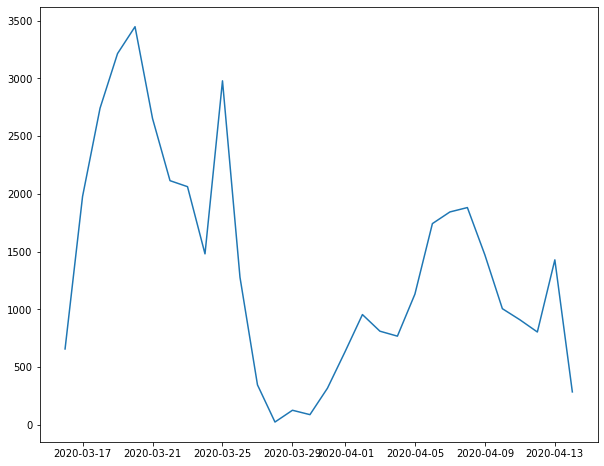

In [138]:
# let's visualize tweet per day..
plt.figure(figsize=(10,8))
plt.plot(tweet_per_day["TweetAt"],tweet_per_day["Sentiment"]);

In [139]:
train_df["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

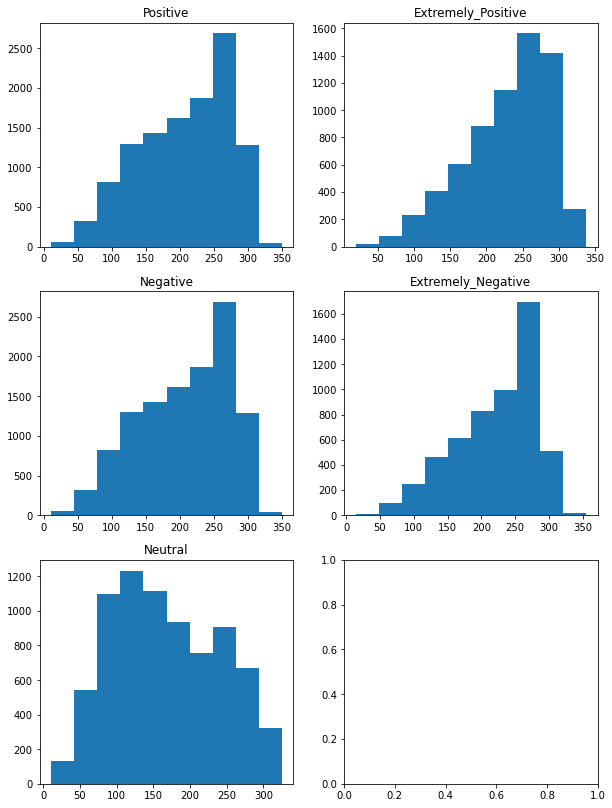

In [140]:
# plotting the number of characters per sentiment
len_neutral = train_df[train_df["Sentiment"]=="Neutral"]["OriginalTweet"].str.len()

# positive sentiment 
len_positive = train_df[train_df["Sentiment"]=="Positive"]["OriginalTweet"].str.len()

# negative sentiment 
len_negative = train_df[train_df["Sentiment"]=="Positive"]["OriginalTweet"].str.len()

# extremely negative 
len_ex_neg = train_df[train_df["Sentiment"]=="Extremely Negative"]["OriginalTweet"].str.len()

# extremely positive
len_ex_pos = train_df[train_df["Sentiment"]=="Extremely Positive"]["OriginalTweet"].str.len()

# let's plot the len of characters in each sentiment category....
# plt.figure(figsize=(10,8))
figure,ax = plt.subplots(3,2,figsize=(10,14))
ax[0,0].hist(len_positive)
ax[0,0].set_title("Positive")

ax[0,1].hist(len_ex_pos)
ax[0,1].set_title("Extremely_Positive")

ax[1,0].hist(len_negative)
ax[1,0].set_title("Negative")

ax[1,1].hist(len_ex_neg)
ax[1,1].set_title("Extremely_Negative")

ax[2,0].hist(len_neutral)
ax[2,0].set_title("Neutral")

plt.show()

In [141]:
train_df[train_df["Sentiment"]== "Positive"]["Length"]

1        237
2        131
3        306
5        250
6        180
        ... 
41140    302
41145    105
41146    290
41150    199
41154    136
Name: Length, Length: 11422, dtype: int64

In [142]:
# change the sentiment type

def change_sen(sentiment):
    if sentiment == "Positive":
        return "positive"
    elif sentiment == "Extremely Positive":
        return "positive"
    elif sentiment == "Negative":
        return "negative"
    elif sentiment == "Extremely Negative":
        return "negative"
    else:
        return "neutral"

In [143]:
train_df["Sentiment"] = train_df["Sentiment"].apply(change_sen)
test_df["Sentiment"] = test_df["Sentiment"].apply(change_sen)

# let's check the changes
train_df["Sentiment"].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

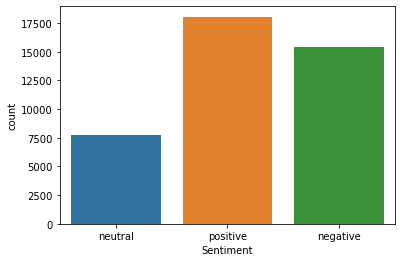

In [144]:
# plot it
sns.countplot(train_df["Sentiment"]);

In [145]:
# as our label is in text so map it

l = {"neutral" : 0, "positive" : 1,"negative" : 2}

# apply it to the data....

train_df["Sentiment"] = train_df["Sentiment"].map(l)
test_df["Sentiment"] = test_df["Sentiment"].map(l)

In [70]:
train_df["Sentiment"] = to_categorical(train_df["Sentiment"],3)
test_df["Sentiment"] = to_categorical(test_df["Sentiment"],3)

In [146]:
train_df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Length
17492,21291,66243,TEXAS,2020-03-23,Where the fuck did they find these vacuous peo...,2,198
35575,39374,84326,"Conroe, TX",2020-04-09,10th Emergency Order of the COVID-19 outbreak ...,2,140
25115,28914,73866,"Exeter, England",2020-03-30,Tonight I'm saying #ThankYou &amp; praying for...,1,218
30036,33835,78787,"Galway, Ireland",2020-04-06,AgFunder: A quick look at the impact of Covid-...,1,137
17664,21463,66415,"Suva, Fiji",2020-03-23,The Consumer Watchdog has seen an increase in ...,2,176
25781,29580,74532,Suffolk,2020-04-01,Hear and I chatting about the latest news from...,2,118
9470,13269,58221,NaN,2020-03-20,Greater demand due to covid-19 causes shortfal...,1,142
37116,40915,85867,NaN,2020-04-10,Minion World I successfully stole a case of to...,1,74
10380,14179,59131,London,2020-03-20,Surely co-working space and office buildings m...,1,285
7404,11203,56155,NaN,2020-03-19,"Just been to Aldi, food warehouse and even B&a...",2,270


In [147]:
train_df["Sentiment"].unique()

array([0, 1, 2])

In [148]:
# split the data into train and test set by picking only main columns
X_train = train_df["OriginalTweet"]
y_train = train_df["Sentiment"]

X_test = test_df["OriginalTweet"]
y_test = test_df["Sentiment"]

# checking the sets...
len(X_train),len(y_train),len(X_test),len(y_test)

(41157, 41157, 3798, 3798)

In [149]:
# let's make a function that will evaluate our model performance....
def calculate_results(y_true,y_pred):
    """
    This function will evaluate our model performace by measuring certain metrics....
    Accuracy : it tells us that how accurately our model predict the label
    Precision : this is the ability of classifier not to label a negative label as positive.
    Recall : this is the ability of classifier to find all positive labels.
    Fscore : this is the average of preicision and recall.
    """
    accuracy = accuracy_score(y_true,y_pred)
    precision_score,recall_score,f_score,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    
    results = {
        "Accuracy" : accuracy ,
        "Precision" : precision_score,
        "Recall" : recall_score,
        "F_Score" : f_score
    }
    return results

In [150]:
def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    
      
    return text

In [151]:
# as our data is in text form so let's first clean it....
# re.sub() --> return the sub-string with replace value

def clean(text):
    
#     remove punctuation marks...
    text = re.sub(r"[^\w\s]","",text)
    
#     remove URL's
    text = re.sub(r'http\S+',"",text)
    
#     remove digits
    text = re.sub(r'\d+',"",text)
    
#     remove HTML tags
    text = re.sub(r"<[^>]*>","",text)
    
#     remove mentions
    text = re.sub(r"@\w+","",text)
    
#     remove hash-tag only #
    text = re.sub(r"#","",text)
    
    return text

In [152]:
# let's apply it to the data....
X_train = X_train.apply(lambda x : clean(x))
X_test = X_test.apply(lambda x : clean(x))


X_train

0                  MeNyrbie Phil_Gahan Chrisitv  and  and 
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia Woolworths to give elder...
3        My food stock is not the only one which is emp...
4        Me ready to go at supermarket during the COVID...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when KameronWilds ...
41155    Is it wrong that the smell of hand sanitizer i...
41156    TartiiCat Well newused Rift S are going for  o...
Name: OriginalTweet, Length: 41157, dtype: object

## Tokenization


As we clean our text let's split the data and convert each split into integer through tokenization because our 
deep learning models works only with the numbers....


In [153]:
# find the average legth of sentence
np.round(sum([len(i.split()) for i in X_train])/len(X_train))

29.0

In [154]:
# find the shortest tweet
np.min([len(i.split()) for i in X_train])

0

In [155]:
# longest tweet
np.max([len(i.split()) for i in X_test])

62

In [156]:
# set the vocabulary and max length for each tweet
max_vocab_len = 15000
max_len = 35

In [157]:
token = TextVectorization(max_tokens=max_vocab_len,
                         output_sequence_length=max_len,
                         output_mode="int",
                         standardize="lower_and_strip_punctuation")

In [158]:
# let's adapt it to the text...
token.adapt(X_train)

2022-09-14 21:49:39.596990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [159]:
# get the text information....
vocab = token.get_vocabulary()
print(f"Most common 5 words in the text : \n\n{vocab[:5]}\n")
print(f"Most least common 5 words in the text : \n\n{vocab[-5:]}")

Most common 5 words in the text : 

['', '[UNK]', 'the', 'to', 'and']

Most least common 5 words in the text : 

['grams', 'gramnow', 'grades', 'grader', 'gra']


In [160]:
# let's take a sample from text and tokenize it...
random_text = random.choice(X_train)

print(f"Original Text : \n\n{random_text}")
print(f"\nTokize Version : \n\n{token([random_text])}")

Original Text : 

Oh no ConsumerSOS my grocery store I just went to the other day Garden Foods in Bolton is shut down  Employe tested positive with symptoms  coronavirus    This is going to be a problem soon when essential services start to get infected

Tokize Version : 

[[ 1039    58     1    38    24    21    15    65   235     3     2   100
    130  2587   813     8 12806    11   616   125     1   571   397    22
    841     9    16    11    85     3    28     7   751   495    73]]


## Embeddings:

As we've tokenized our data, let's embedd it which is the richer representation of the data.

In [161]:
embedd = Embedding(input_dim = max_vocab_len,
                  output_dim = 128,
                   input_length = max_len,
                   embeddings_initializer='uniform',
                  )

In [162]:
# let's take a sample from text, tokenize and embedd it...
random_text = random.choice(X_train)

print(f"Original Text : \n\n{random_text}")
print(f"\nTokize Version : \n\n{token([random_text])}")
print(f"\nEmbedd Version : \n\n{embedd(token([random_text]))}")

Original Text : 

seanhannity Cat milk shortage reported in Oklahoma Prices skyrocket amid COVID crisis Only available from private dairies 

Tokize Version : 

[[9092 2396  425  431 1199    8 4473   17 2258  157    5   94  104  253
    31 1167    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]

Embedd Version : 

[[[-4.6541549e-02  2.4537694e-02 -5.8120489e-04 ... -4.4926204e-02
    3.9018940e-02  3.0459497e-02]
  [ 8.6570904e-04  2.9489469e-02 -1.1846531e-02 ... -6.4760335e-03
    2.5729660e-02 -2.5050569e-02]
  [ 2.2261772e-02 -4.6756744e-02  4.0552404e-02 ...  3.2536175e-02
   -2.3011481e-02  3.9832246e-02]
  ...
  [-1.8820703e-02  3.2634128e-02  1.8494558e-02 ... -9.2375055e-03
    7.6599605e-03 -7.7534467e-05]
  [-1.8820703e-02  3.2634128e-02  1.8494558e-02 ... -9.2375055e-03
    7.6599605e-03 -7.7534467e-05]
  [-1.8820703e-02  3.2634128e-02  1.8494558e-02 ... -9.2375055e-03
    7.6599605e-03 -7.7534467e-05]]]


## Model building

    ~We'll build a series of model and pick the one that performs better.
    ~Naive Model
    ~Dense Model
    ~LSTM Model
    ~GRU Model
    ~BiDirectional Model
    ~Convolutional Model

## Naive Model

In [163]:
# let's build the naive model
clf = Pipeline([
    ("Tfidf",TfidfVectorizer()),
    ("NB",MultinomialNB())
])

clf.fit(X_train,y_train)

Pipeline(steps=[('Tfidf', TfidfVectorizer()), ('NB', MultinomialNB())])

In [164]:
# model prediction....
model_0_pred = clf.predict(X_test)
model_0_pred[:5]

array([2, 1, 1, 2, 2])

In [165]:
# calculate model results....
model_0_results = calculate_results(y_test,model_0_pred)
model_0_results

{'Accuracy': 0.6253291205897841,
 'Precision': 0.6663493750431053,
 'Recall': 0.6253291205897841,
 'F_Score': 0.5695089252633851}

In [166]:
X_train.shape[0]

41157

## Model 1 : Dense Model

In [168]:
# previously we build scikit-learn naive model, let's build our first deep learning model...

# define the input layer.....
inputs = layers.Input(shape=(1,),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(64,activation="relu")(x)
# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the output layer....
# adding the globalaverage layer...
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_1 = tensorflow.keras.Model(inputs,output,name="Dense_Model")

# compiling the model...
model_1.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])



In [170]:
# checking the model summary
model_1.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 35)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 35, 128)           1920000   
                                                                 
 dense_30 (Dense)            (None, 35, 64)            8256      
                                                                 
 dense_31 (Dense)            (None, 35, 32)            2080      
                                                                 
 global_average_pooling1d_6   (None, 32)               0         
 (GlobalAveragePooling1D)                              

In [172]:
X_train.shape

(41157,)

In [173]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [175]:
# fitting the model to data....
history_1 = model_1.fit(X_train,y_train,
                       epochs=50,
                       validation_data=(X_test,y_test),
                        validation_split = int(len(X_test) * 0.25),)
#                         callbacks = [tensorflow.keras.callbacks.ModelCheckpoint("Dense_1.keras",
#                                                                                save_best_only=True)])

Epoch 1/50
1287/1287 [==============================] - 22s 17ms/step - loss: 0.5261 - accuracy: 0.8207 - val_loss: 0.6147 - val_accuracy: 0.7778
Epoch 2/50
1287/1287 [==============================] - 23s 18ms/step - loss: 0.4816 - accuracy: 0.8409 - val_loss: 0.6045 - val_accuracy: 0.7896
Epoch 3/50
1287/1287 [==============================] - 22s 17ms/step - loss: 0.4577 - accuracy: 0.8505 - val_loss: 0.6130 - val_accuracy: 0.7880
Epoch 4/50
1287/1287 [==============================] - 22s 17ms/step - loss: 0.4424 - accuracy: 0.8558 - val_loss: 0.6249 - val_accuracy: 0.7783
Epoch 5/50
1287/1287 [==============================] - 22s 17ms/step - loss: 0.4292 - accuracy: 0.8615 - val_loss: 0.6266 - val_accuracy: 0.7746
Epoch 6/50
1287/1287 [==============================] - 22s 17ms/step - loss: 0.4183 - accuracy: 0.8655 - val_loss: 0.6193 - val_accuracy: 0.7862
Epoch 7/50
1287/1287 [==============================] - 22s 17ms/step - loss: 0.4096 - accuracy: 0.8689 - val_loss: 0.6338 -

In [178]:
# evaluate model performance....
model_1_pred = model_1.predict(X_test)
model_1_pred

119/119 [==============================] - 1s 4ms/step


array([[8.8064998e-02, 1.6351417e-01, 7.4842083e-01],
       [2.7824037e-03, 9.9657840e-01, 6.3916040e-04],
       [5.1152841e-03, 9.9396235e-01, 9.2231046e-04],
       ...,
       [8.6142796e-01, 1.0287981e-01, 3.5692230e-02],
       [6.9139749e-03, 1.7603252e-04, 9.9291003e-01],
       [1.9374766e-05, 9.9997544e-01, 5.1278694e-06]], dtype=float32)

In [179]:
model_1_pred = tf.squeeze(tf.round(model_1_pred))
model_1_pred

<tf.Tensor: shape=(3798, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [ ]:
# calculate_results
model_1_resutls = 